In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import os
from IPython.display import display, clear_output
import scipy.optimize as spo
import iminuit
import uproot
import json
import multiprocessing as mp
import time
from scipy.optimize import curve_fit

In [2]:
def gaussian(x, a,mu,sig):
        return a/(math.sqrt(2.*math.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def leastsquare(a,mu,sig):  #parameter: mu,sigma and (nu?! is nu = mu?!)
    return sum((gaussian(x,a,mu,sig)-y)**2 for x, y in zip(chosen_bin, chosen_yhist))

In [3]:
def plot_spectra(PE=1,angle=0):
    print(f'Results with {PE} PE at angle {angle} deg')
    bin_number = 150
    
    stat = np.load(f'electron_counts/electron_count_{PE}PE_{angle}angle.npy')
    e_ID = np.load(f'electron_counts/electron_count_event_{PE}PE_{angle}angle.npy')
    area_collection = np.load(f'electron_counts/electron_count_area_{PE}PE_{angle}angle.npy')
    Edep_dist = np.load(f'electron_counts/electron_count_energy_{PE}PE_{angle}angle.npy')
    
    area_straight_list = np.array([area_collection[i] for i in e_ID[0]])
    area_returning_list = np.array([area_collection[i] for i in e_ID[1]]) 
    area_non_list = np.array([area_collection[i] for i in e_ID[2]])
    
    yhist,binedges = np.histogram(area_straight_list,bins=bin_number)
    yhistr,binedgesr = np.histogram(area_returning_list,bins=bin_number)
    yhistn,binedgesn = np.histogram(area_non_list,bins=bin_number)
    bc = np.array((binedges[1:] + binedges[:-1])/2)
    #plt.figure(figsize=(8,4.5))
    #plt.plot(binedges[1:],yhist,label='straight')
    #plt.plot(binedges[1:],yhistr,label='returning')
    #plt.plot(binedges[1:],yhistn,label='non-returning')
    #plt.legend()
    
    peak_index = np.argmax(yhist)
    left = 30
    right = len(yhist)-peak_index - 1

    global chosen_bin
    global chosen_yhist

    chosen_bin = bc[peak_index-left:peak_index+right]
    chosen_yhist= yhist[peak_index-left:peak_index+right]
    
    #m = iminuit.Minuit(leastsquare,a=max(yhist),mu=bc[peak_index],sig=500,error_a=100, error_mu=100,error_sig=500,errordef=0.5)
    #m = iminuit.Minuit(leastsquare,a=max(yhist),mu=bc[peak_index],sig=2000)
    #m.migrad()
    #m.hesse()
    #print(m.values)
    ##print(m.errors)

    x= np.linspace(200,12000,6000)
    #y = gaussian(x,m.values[0],m.values[1],m.values[2])
    
    popt, pcov = curve_fit(gaussian, chosen_bin, chosen_yhist,
                           p0=(max(yhist), bc[peak_index],1000))
    #print('Fit results',*popt)
    perr = np.sqrt(np.diag(pcov))
    y = gaussian(x, *popt)
    plt.figure(figsize=(8,4.5))
    plt.scatter(bc,yhist,label = "Straight electrons distribution")
    plt.scatter(chosen_bin,chosen_yhist,color='r',label="Fitting Data Points")
    plt.plot(x,y,label='Gaussian Fit',color = 'black')
    plt.axvline(bc[peak_index-left],color='red',linestyle=":")
    plt.axvline(bc[peak_index+right],color='red',linestyle=":",label = "Fitting Range")
    plt.ylim(0)
    plt.legend(prop={'size': 8})
    plt.show()
    
    print(" ** Summary of the electrons ** ")
    print(f'Total electrons: {np.sum(stat)}')
    print(f'Portion of straight electrons: {(stat[0])/np.sum(stat):.2f}')
    print(f'Portion of returning back-scattered electrons: {(stat[1])/np.sum(stat):.2f}')
    print(f'Portion of non-returning back-scattered electrons: {(stat[2])/np.sum(stat):.2f}')
    print(f'Portion of back-scattered electrons (returning+non-returning): {(stat[1]+stat[2])/np.sum(stat):.2f}')
    print(f'Portion of undetected electrons: {(stat[3])/np.sum(stat):.2f}')

    ########################
    ########################
    
    fig, axs = plt.subplots(2,2,figsize=(13,8))
    axs[0,0].hist(area_straight_list,bins=bin_number,label = "Straight e-",histtype='step',color='g') #,normed=True
    axs[0,0].hist(area_returning_list,bins=bin_number,label = "Returning e-",histtype='step',color='b') #,normed=True
    axs[0,0].hist(area_non_list,bins=bin_number,label = "Non-returning",histtype='step',color='r') #,log=True   ,normed=True
    axs[0,0].plot(x,y,label="Gaussian Fit",color = 'black')
    axs[0,0].set_title("SiPM area count",fontsize=11)
    axs[0,0].legend(prop={'size': 8})
    axs[0,0].set(xlabel="Area")
    axs[0,0].relim()
    axs[0,0].autoscale_view()

    axs[1,0].hist(Edep_dist[0],bins=bin_number,histtype='step',label = "Straight e-",color='g') #,log=True
    axs[1,0].hist(Edep_dist[1],bins=bin_number,histtype='step',label = "Returning e-",color='b') #,log=True
    axs[1,0].hist(Edep_dist[2],bins=bin_number,histtype='step',label = "Non-retrurning",color='r')
    axs[1,0].set_title("Energy deposited",fontsize=11)
    axs[1,0].set(xlabel="Energy (keV)")
    axs[1,0].legend(prop={'size': 8})

    axs[0,1].hist(area_straight_list,bins=bin_number,label = "Straight e-",histtype='step',color='g',log=True) #,normed=True
    axs[0,1].hist(area_returning_list,bins=bin_number,label = "Returning e-",histtype='step',color='b',log=True) #,normed=True
    axs[0,1].hist(area_non_list,bins=bin_number,label = "Non-returning",histtype='step',color='r',log=True) #,log=True   ,normed=True
    axs[0,1].set_title("SiPM area count (log-scale)",fontsize=11)
    axs[0,1].legend(prop={'size': 8})
    axs[0,1].set(xlabel='Area')

    axs[1,1].hist(Edep_dist[0],bins=bin_number,histtype='step',color='g',label = "Straight e-",log=True) #,log=True
    axs[1,1].hist(Edep_dist[1],bins=bin_number,histtype='step',color='b',label = "Returning e-",log=True) #,log=True
    axs[1,1].hist(Edep_dist[2],bins=bin_number,histtype='step',color='r',label = "Non-returning",log=True) #,log=True
    axs[1,1].legend(prop={'size': 8})
    axs[1,1].set_title("Energy depposited (log-scale)",fontsize=11)
    axs[1,1].set(xlabel="Energy (keV)")

    fig.suptitle(str(PE)+ " PE event Spectra at angle "+str(angle)+" deg",fontsize=12)
    plt.subplots_adjust(hspace = 0.25)
    path = './plots/'
    if not os.path.exists(path):
        os.makedirs(path)
        
    plt.savefig(path+"Spectra_"+str(PE)+"_pe_angle_"+str(angle)) 
    plt.show()

Results with 1 PE at angle 0 deg


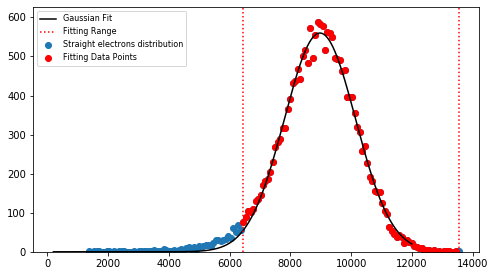

 ** Summary of the electrons ** 
Total electrons: 35000
Portion of straight electrons: 0.59
Portion of returning back-scattered electrons: 0.04
Portion of non-returning back-scattered electrons: 0.36
Portion of back-scattered electrons (returning+non-returning): 0.40
Portion of undetected electrons: 0.01


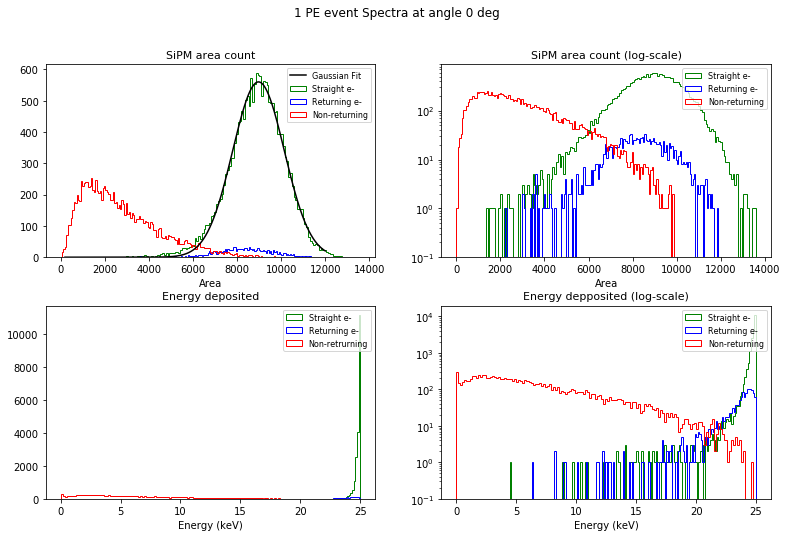

Results with 1 PE at angle 15 deg


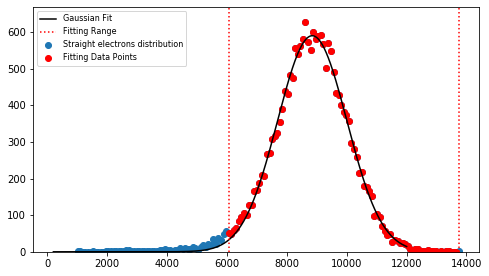

 ** Summary of the electrons ** 
Total electrons: 35000
Portion of straight electrons: 0.58
Portion of returning back-scattered electrons: 0.04
Portion of non-returning back-scattered electrons: 0.36
Portion of back-scattered electrons (returning+non-returning): 0.40
Portion of undetected electrons: 0.01


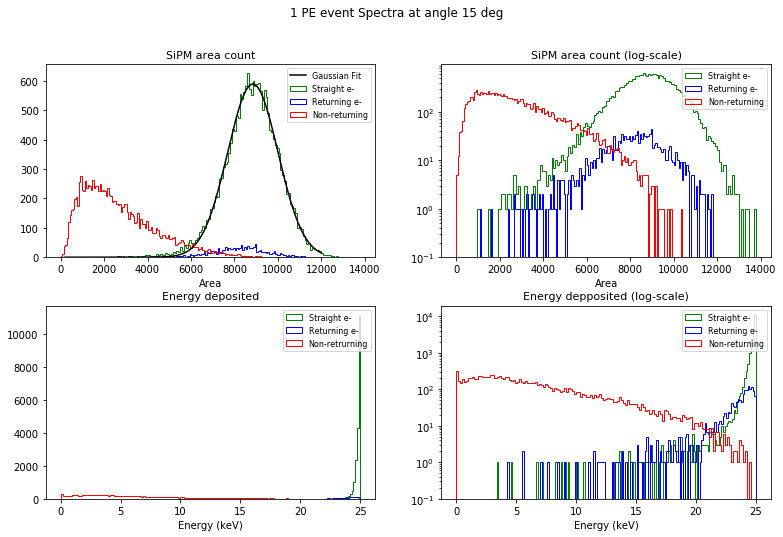

Results with 1 PE at angle 30 deg


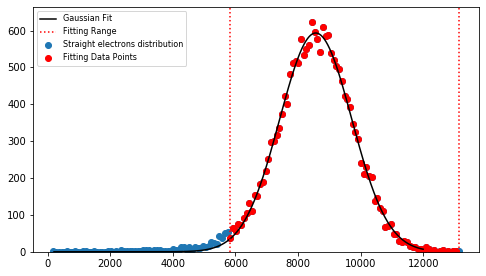

 ** Summary of the electrons ** 
Total electrons: 35000
Portion of straight electrons: 0.57
Portion of returning back-scattered electrons: 0.04
Portion of non-returning back-scattered electrons: 0.37
Portion of back-scattered electrons (returning+non-returning): 0.41
Portion of undetected electrons: 0.02


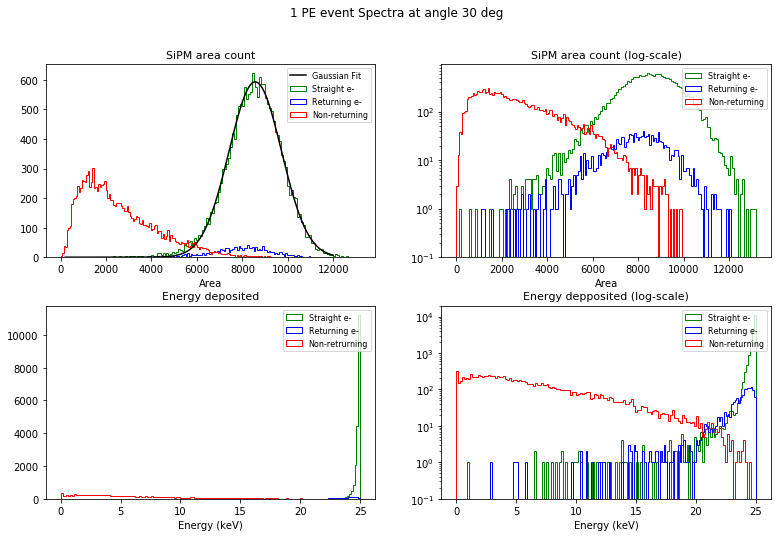

Results with 1 PE at angle 45 deg


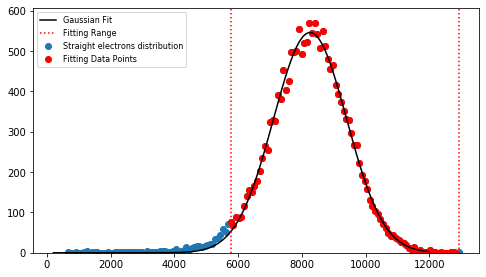

 ** Summary of the electrons ** 
Total electrons: 35000
Portion of straight electrons: 0.56
Portion of returning back-scattered electrons: 0.04
Portion of non-returning back-scattered electrons: 0.39
Portion of back-scattered electrons (returning+non-returning): 0.43
Portion of undetected electrons: 0.02


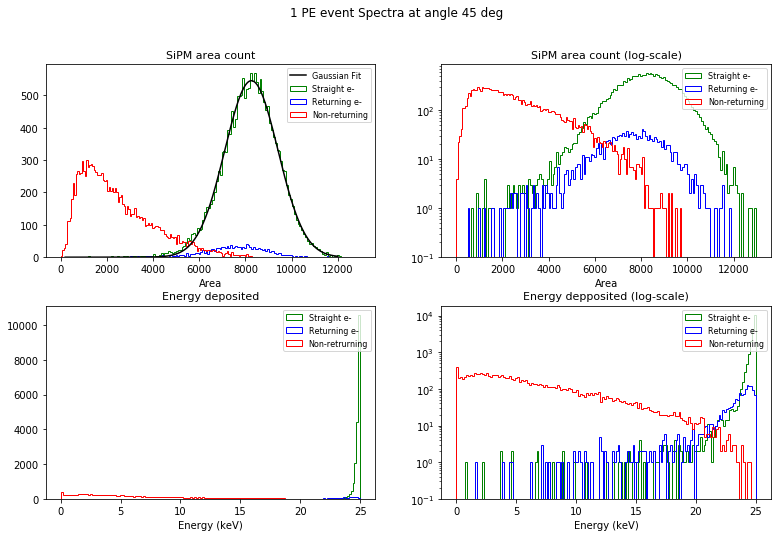

Results with 1 PE at angle 60 deg


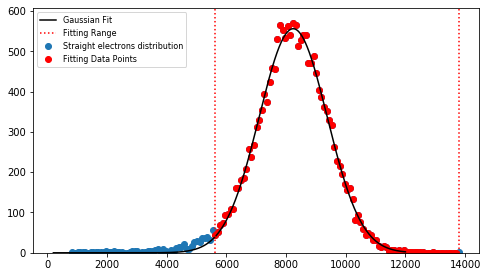

 ** Summary of the electrons ** 
Total electrons: 35000
Portion of straight electrons: 0.53
Portion of returning back-scattered electrons: 0.04
Portion of non-returning back-scattered electrons: 0.40
Portion of back-scattered electrons (returning+non-returning): 0.44
Portion of undetected electrons: 0.02


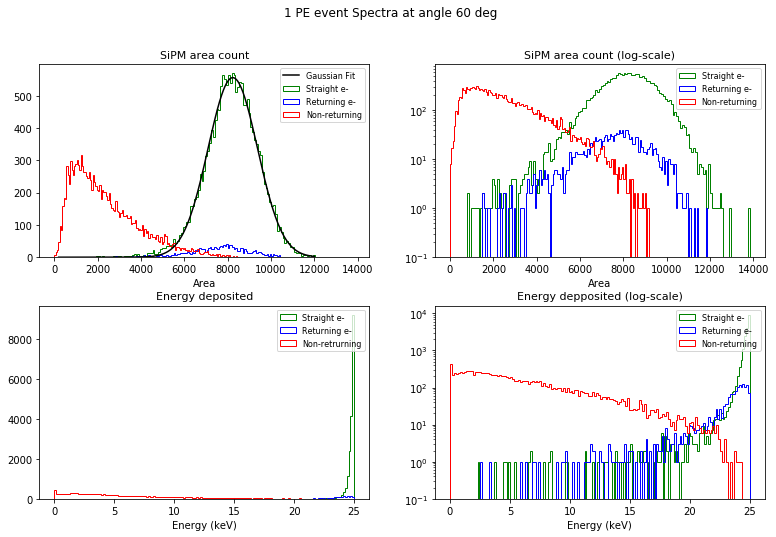

Results with 1 PE at angle 75 deg


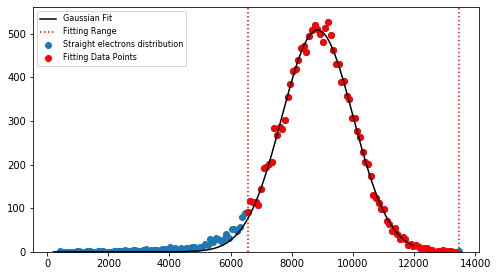

 ** Summary of the electrons ** 
Total electrons: 35000
Portion of straight electrons: 0.50
Portion of returning back-scattered electrons: 0.05
Portion of non-returning back-scattered electrons: 0.42
Portion of back-scattered electrons (returning+non-returning): 0.47
Portion of undetected electrons: 0.03


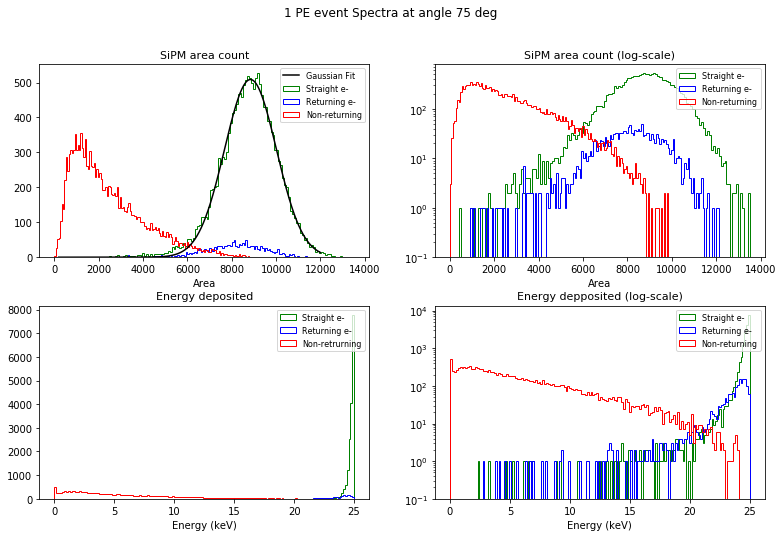

Results with 1 PE at angle 83 deg


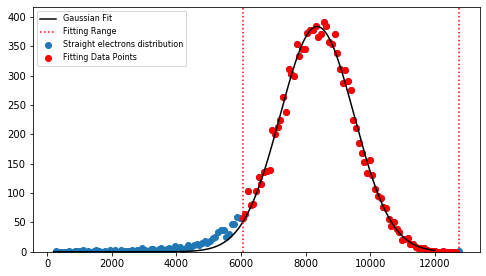

 ** Summary of the electrons ** 
Total electrons: 35000
Portion of straight electrons: 0.39
Portion of returning back-scattered electrons: 0.04
Portion of non-returning back-scattered electrons: 0.36
Portion of back-scattered electrons (returning+non-returning): 0.40
Portion of undetected electrons: 0.22


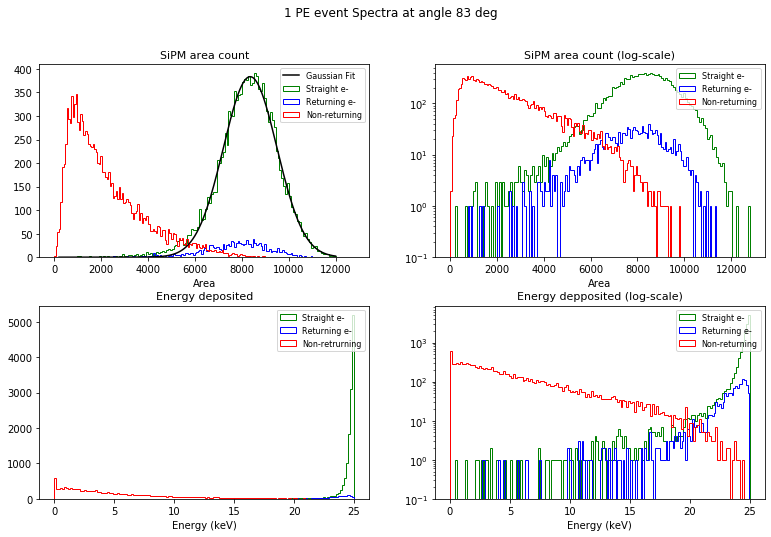

Results with 1 PE at angle 85 deg


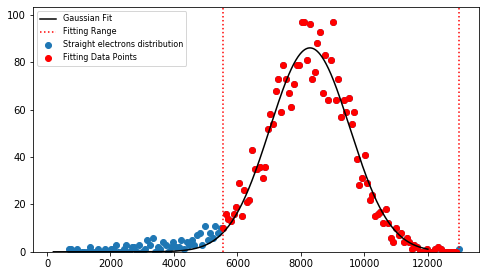

 ** Summary of the electrons ** 
Total electrons: 35000
Portion of straight electrons: 0.10
Portion of returning back-scattered electrons: 0.01
Portion of non-returning back-scattered electrons: 0.11
Portion of back-scattered electrons (returning+non-returning): 0.12
Portion of undetected electrons: 0.78


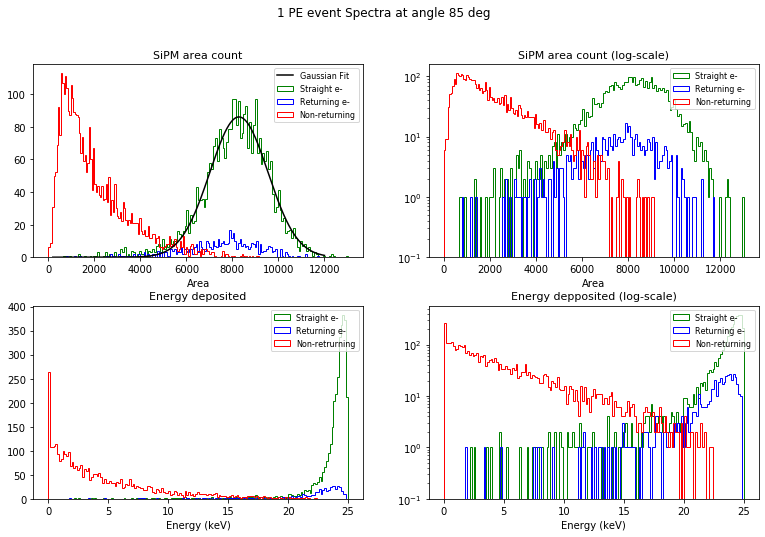

In [4]:
angles = [0,15,30,45,60,75,83,85]
for ang in angles:
    plot_spectra(PE=1,angle=ang)
#plot_spectra(pe1_ang0)
#plot_spectra(pe1_ang15)
#plot_spectra(pe1_ang30)
#plot_spectra(pe1_ang45)
#plot_spectra(pe1_ang60)
#plot_spectra(pe1_ang75)
#plot_spectra(pe1_ang85)

In [5]:
def e_stat_bootstrap(PE=1,angle=0):
    e_stat = np.load(f'electron_counts/electron_count_{PE}PE_{angle}angle.npy')
    e_ID = np.load(f'electron_counts/electron_count_event_{PE}PE_{angle}angle.npy')
    area_collection = np.load(f'electron_counts/electron_count_area_{PE}PE_{angle}angle.npy')
    Edep_dist = np.load(f'electron_counts/electron_count_energy_{PE}PE_{angle}angle.npy')
    
    s = np.ones(e_stat[0])
    r = np.ones(e_stat[1])*2
    nr = np.ones(e_stat[2])*3
    ne = np.ones(e_stat[3])*4
    sample = np.concatenate([s, r,nr,ne], axis=None)
    
    bootstrap_trials = 10000
    bootstrap_nr_portion = []
    bootstrap_s_portion = []
    bootstrap_r_portion = []
    bootstrap_ne_portion= []
    
    for x in range(0, bootstrap_trials):
        bootstrap_data = np.random.choice(sample, 8000, replace=True)
        # count the number of non-returning back-scattered e-
        bootstrap_nr_stat = np.sum(bootstrap_data == 3)/len(bootstrap_data)
        bootstrap_s_stat = np.sum(bootstrap_data == 1)/len(bootstrap_data)
        bootstrap_r_stat = np.sum(bootstrap_data == 2)/len(bootstrap_data)
        bootstrap_ne_stat = np.sum(bootstrap_data == 4)/len(bootstrap_data)

        bootstrap_nr_portion += [np.average(bootstrap_nr_stat)]
        bootstrap_s_portion += [np.average(bootstrap_s_stat)]
        bootstrap_r_portion += [np.average(bootstrap_r_stat)]
        bootstrap_ne_portion += [np.average(bootstrap_ne_stat)]
        
    bootstrap_nr_sorted = np.sort(bootstrap_nr_portion)
    bootstrap_ne_sorted = np.sort(bootstrap_ne_portion)
    bootstrap_s_sorted = np.sort(bootstrap_s_portion)
    bootstrap_r_sorted = np.sort(bootstrap_r_portion)
    plt.figure(figsize=(8,4.5))
    plt.hist(bootstrap_nr_portion,bins=25)
    plt.axvline(bootstrap_nr_sorted[int(bootstrap_trials*0.05)],color='r')
    plt.axvline(bootstrap_nr_sorted[int(bootstrap_trials*0.95)],color='r')
    plt.title("Bootstrapping of the portion of NRBE at " + str(PE) + " pe angle "+str(angle)+" deg",fontsize=11)
    path = "./plots/NRBE/"
    if not os.path.exists(path):
        os.makedirs(path)
        
    plt.savefig(path+str(PE)+"_pe_angle_"+str(angle))
    plt.show()
    
    nr_stat = [np.median(bootstrap_nr_portion),bootstrap_nr_sorted[int(bootstrap_trials*0.05)],\
               bootstrap_nr_sorted[int(bootstrap_trials*0.95)],np.std(bootstrap_nr_portion)]
    ne_stat = [np.median(bootstrap_ne_portion),bootstrap_ne_sorted[int(bootstrap_trials*0.05)],\
               bootstrap_ne_sorted[int(bootstrap_trials*0.95)],np.std(bootstrap_ne_portion)]
    s_stat = [np.median(bootstrap_s_portion),bootstrap_s_sorted[int(bootstrap_trials*0.05)],\
               bootstrap_s_sorted[int(bootstrap_trials*0.95)],np.std(bootstrap_s_portion)]
    r_stat = [np.median(bootstrap_r_portion),bootstrap_r_sorted[int(bootstrap_trials*0.05)],\
               bootstrap_r_sorted[int(bootstrap_trials*0.95)],np.std(bootstrap_r_portion)]
    return [s_stat,r_stat,nr_stat,ne_stat]

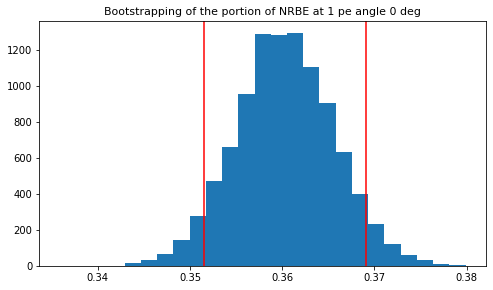

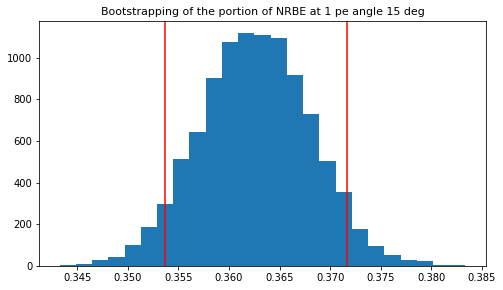

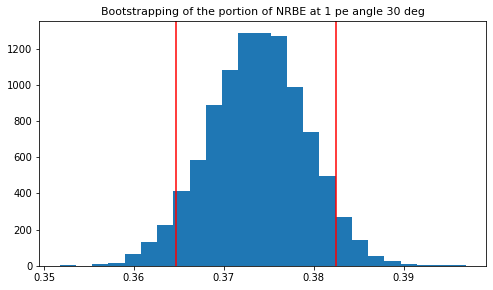

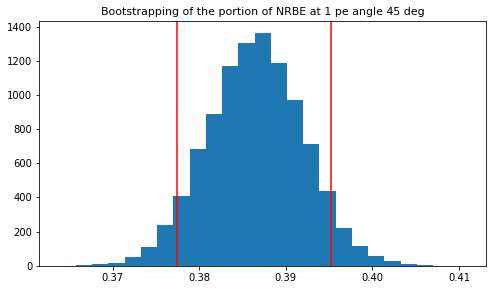

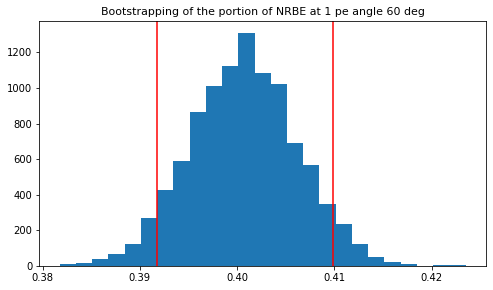

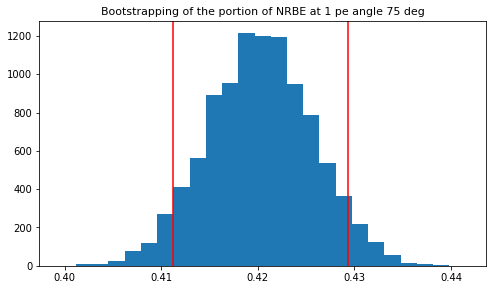

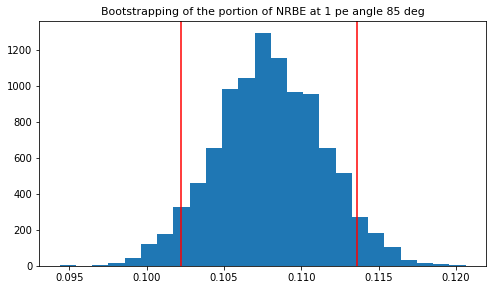

In [6]:
stat_1_0=e_stat_bootstrap(PE=1,angle=0)
stat_1_15=e_stat_bootstrap(PE=1,angle=15)
stat_1_30=e_stat_bootstrap(PE=1,angle=30)
stat_1_45=e_stat_bootstrap(PE=1,angle=45)
stat_1_60=e_stat_bootstrap(PE=1,angle=60)
stat_1_75=e_stat_bootstrap(PE=1,angle=75)
stat_1_85=e_stat_bootstrap(PE=1,angle=85)

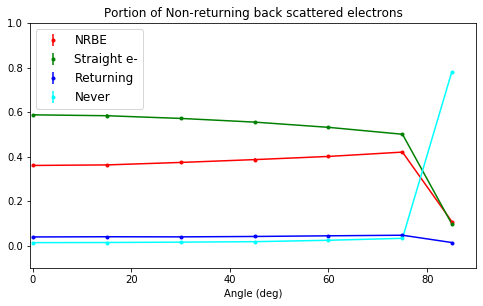

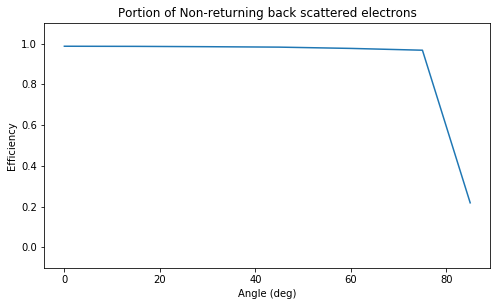

In [7]:
stat_set = [stat_1_0,stat_1_15,stat_1_30,stat_1_45,stat_1_60,stat_1_75,stat_1_85]

SE = [i[0][0] for i in stat_set]
SE_var = [i[0][3] for i in stat_set]
RE = [i[1][0] for i in stat_set]
RE_var = [i[1][3] for i in stat_set]
NRBE = [i[2][0] for i in stat_set]
NRBE_var = [i[2][3] for i in stat_set]
NE = [i[3][0] for i in stat_set]
NE_var = [i[3][3] for i in stat_set]

angle = [0,15,30,45,60,75,85]
plt.figure(figsize=(8,4.5))
plt.errorbar(angle,NRBE,yerr=NRBE_var,fmt='.',label="NRBE",color="Red")
plt.errorbar(angle,SE,yerr=SE_var,fmt='.',label="Straight e-",color="Green")
plt.errorbar(angle,RE,yerr=RE_var,fmt='.',label="Returning",color="Blue")
plt.errorbar(angle,NE,yerr=NE_var,fmt='.',label="Never",color="cyan")

plt.plot(angle,NRBE,color="Red")
plt.plot(angle,SE,color="Green")
plt.plot(angle,RE,color="Blue")
plt.plot(angle,NE,color="cyan")


plt.ylim(-0.1,1)
plt.xlim(-0.5,90)

plt.title("Portion of Non-returning back scattered electrons")
plt.xlabel('Angle (deg)')
path = "./plots/NRBE/"
plt.legend(fontsize=12)
plt.savefig(path+"Portion",transparent=False)
plt.show()

plt.figure(figsize=(8,4.5))
eff = np.array([stat_1_0[3][0],stat_1_15[3][0],stat_1_30[3][0],stat_1_45[3][0],stat_1_60[3][0],stat_1_75[3][0],stat_1_85[3][0]])
plt.plot(np.array([0,15,30,45,60,75,85]),1-eff)
plt.title("Portion of Non-returning back scattered electrons")
plt.xlabel('Angle (deg)')
plt.ylabel('Efficiency')
plt.ylim(-0.1,1.1)
path = "./plots/NRBE/"
plt.savefig(path+"Detector_Efficiency",transparent=False)
plt.show()


### Comparing with the tracking data

In [44]:
stat_1_85

[0.139125, 0.13275, 0.1455, 0.003816448971045432]

### Reponses time of ABALONE -- only consider the total time for event

The peak at time ~ 1.9 ns should be the time for most photons being generated in the scinillator

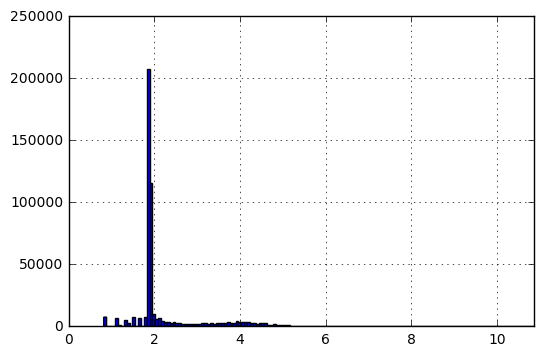

In [251]:
values = df["Time"].iloc[df["Time"].nonzero()] 
values.hist(bins=150)
plt.xlim(0,max(values))
plt.show()

## ----- END ----- 

codes below are only reserved.

In [ ]:
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent


fig, axs = plt.subplots(2, 2)

# Generate some test data
x = np.random.randn(1000)
y = np.random.randn(1000)

sigmas = [0, 16, 32, 64]

for ax, s in zip(axs.flatten(), sigmas):
    if s == 0:
        ax.plot(x, y, 'k.', markersize=5)
        ax.set_title("Scatter plot")
    else:
        img, extent = myplot(x, y, s)
        ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)

plt.show()

### Estimation of Non-returning backscattered electrons

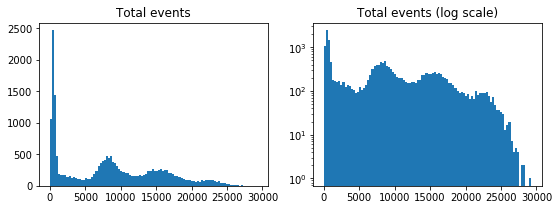

11869 23096 11500 6538


In [30]:
total_area_collection = area_collection_0pe[0:5000] + area_collection_1pe[0:5000]+area_collection_2pe[0:5000]+area_collection_3pe[0:5000] #+area_collection_4pe
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(9,3))
ax[0].hist(total_area_collection,bins=100)
ax[1].hist(total_area_collection,bins=100,log=True)
ax[0].title.set_text("Total events")
ax[1].title.set_text("Total events (log scale)")
plt.show()
fig.savefig("Total_events.png",transparent=False)
# there is no need to have too many data on the 0 pe event


print(len(area_collection_0pe),len(area_collection_1pe),len(area_collection_2pe),len(area_collection_3pe))

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(sample_0,color = 'green',label="0 pe")
ax.plot(sample_1,color = 'blue',label="1 pe")
ax.plot(sample_2,color = 'red',label="2 pe")

ax.title.set_text("SiPM readout for different pe events")
plt.legend()

fig.savefig("SiPM_readout.png",transparent=False)
plt.show()

In [9]:
print(len(area_collection_0pe),len(area_collection_1pe),len(area_collection_2pe))

8084 10745 11500


In [33]:
a = [1,2,3,4,5,6,7,8]
print(a[1,2,3])

TypeError: list indices must be integers, not tuple